# Covid-19 Death Case Prediction

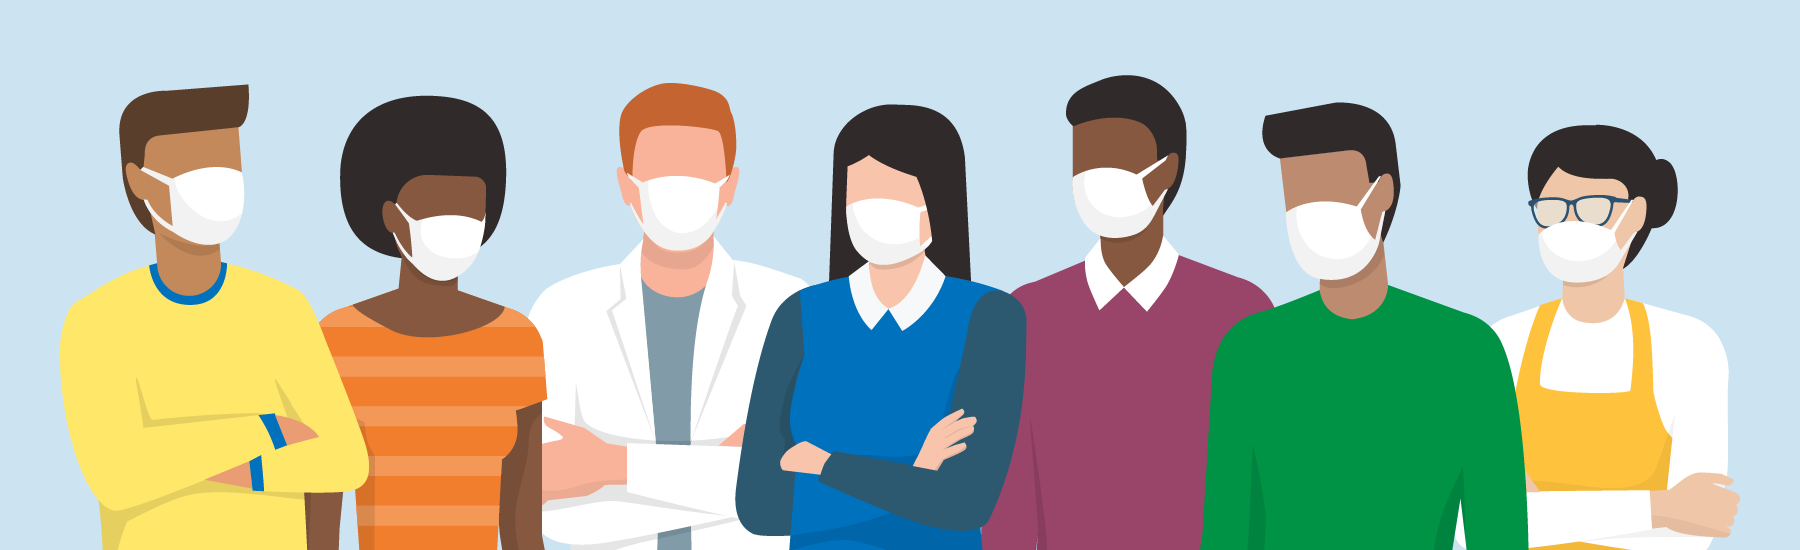

In [3]:
from IPython.display import Image
Image(filename='covid-header-2.png')

This notebook will show the steps to train machine learning models to predict the death case of a patient with Covid-19.

Models used:
* Logistic Regression 
* Decision Tree
* Random Forest
* KNeighbors Classifier

## Data

Context

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.

The raw dataset consists of 21 unique numerical features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.
* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
* degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [4]:
#import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#read csv file
df = pd.read_csv("Covid Data.csv")

In [6]:
print(df.shape)
df.head()

(1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [8]:
df.isna().sum().sum()

0

In [9]:
#class distribution
target_column = 4  # 0-based index of the column to count (the 5th column)
target_value = '9999-99-99' #which means the patient is still alive

counts = df.iloc[:, target_column].value_counts().to_dict()
target_count = counts.get(target_value, 0)
other_count = sum(counts.values()) - target_count

print(f"Number of '{target_value}' in column {target_column + 1}: {target_count}")
print(f"Number of other values in column {target_column + 1}: {other_count}")

Number of '9999-99-99' in column 5: 971633
Number of other values in column 5: 76942


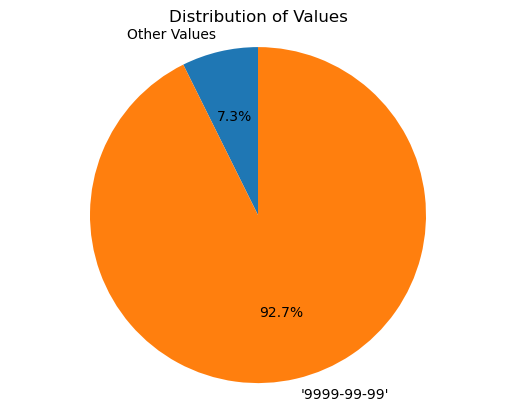

In [10]:
#check the target variable distribution and see if there is any imbalance issue
labels = [f"Other Values", f"'{target_value}'"]
sizes = [other_count, target_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title(f"Distribution of Values")
plt.show()
#the plot shows data imbalance issue, will fix this later in this notebook before applying model

Pandas reads the file and finds that it is data in the shape of (1048575, 21), and most of the data types are integers, and in the feature of the date of death, the proportion of non-dead is far greater than the number of people who died, through the pie The figure can show that 92.7% of the patients did not die.

## data preprocessing

In [11]:
## "97" or "99" indicates missing values, so need to drop them(), only keep instance with value '1' or '2'
cols = ['PNEUMONIA','DIABETES', 'COPD', 'ASTHMA', 'INMSUPR','HIPERTENSION', 
        'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY','RENAL_CHRONIC', 'TOBACCO']
for col in cols :
    df = df[(df[col] == 1)|(df[col] == 2)]

In [12]:
# "9999-99-99" means the patient is alive
df["DEATH"] = [2 if each=="9999-99-99" else 1 for each in df.DATE_DIED]

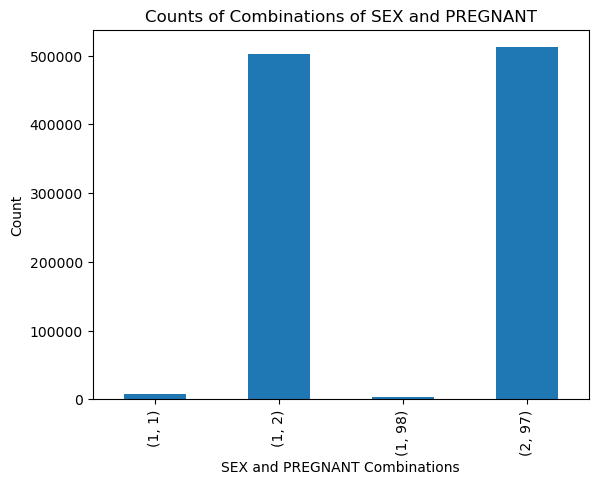

In [13]:
#based on common sense, pregnant feature related to sex, so I explore these 2 features and modify pregnant column
counts = df.groupby(['SEX', 'PREGNANT']).size()

# Create a bar chart of the counts
counts.plot(kind='bar')
plt.title('Counts of Combinations of SEX and PREGNANT')
plt.xlabel('SEX and PREGNANT Combinations')
plt.ylabel('Count')
plt.show()

In [14]:
#all "97" values are for males and males can not be pregnant so we will convert 97 to 2.
df.PREGNANT = df.PREGNANT.replace(97,2)
df = df[(df.PREGNANT == 1) | (df.PREGNANT == 2)]

In [15]:
#check missing values
print('Percentage of missing values')
for col in df.columns :
    print('{:<20} => {:>10.2f}%'.format(col, len(df[(df[col]==98) | (df[col]==99) | (df[col]==97)])/len(df)*100))

Percentage of missing values
USMER                =>       0.00%
MEDICAL_UNIT         =>       0.00%
SEX                  =>       0.00%
PATIENT_TYPE         =>       0.00%
DATE_DIED            =>       0.00%
INTUBED              =>      81.46%
PNEUMONIA            =>       0.00%
AGE                  =>       0.03%
PREGNANT             =>       0.00%
DIABETES             =>       0.00%
COPD                 =>       0.00%
ASTHMA               =>       0.00%
INMSUPR              =>       0.00%
HIPERTENSION         =>       0.00%
OTHER_DISEASE        =>       0.00%
CARDIOVASCULAR       =>       0.00%
OBESITY              =>       0.00%
RENAL_CHRONIC        =>       0.00%
TOBACCO              =>       0.00%
CLASIFFICATION_FINAL =>       0.00%
ICU                  =>      81.48%
DEATH                =>       0.00%


In [16]:
#'INTUBED' and 'ICU' features have too many missing values and the dataset size is large enough,
# so I drop the two features
#"DATE_DIED" can be dropped because it has been converted to the "DEATH" feature.
df.drop(columns=["INTUBED","ICU","DATE_DIED"], inplace=True)

In [17]:
for i in df.columns:
    print(i,"=>\t",len(df[i].unique()))

USMER =>	 2
MEDICAL_UNIT =>	 13
SEX =>	 2
PATIENT_TYPE =>	 2
PNEUMONIA =>	 2
AGE =>	 121
PREGNANT =>	 2
DIABETES =>	 2
COPD =>	 2
ASTHMA =>	 2
INMSUPR =>	 2
HIPERTENSION =>	 2
OTHER_DISEASE =>	 2
CARDIOVASCULAR =>	 2
OBESITY =>	 2
RENAL_CHRONIC =>	 2
TOBACCO =>	 2
CLASIFFICATION_FINAL =>	 7
DEATH =>	 2


In [18]:
categorical=0
numerical=0
numerical_feature=[]
categorical_feature=[]
for i in df.columns:
        if len(set(df.loc[:,i]))==2:
            categorical+=1
            categorical_feature.append(i)
        else:
            numerical+=1
            numerical_feature.append(i)
print(numerical_feature,categorical_feature)
#'MEDICAL_UNIT', 'AGE','CLASIFFICATION_FINAL' are numerical features or multi-category features, others are Binary features

['MEDICAL_UNIT', 'AGE', 'CLASIFFICATION_FINAL'] ['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'DEATH']


Text(0.5, 1.0, 'Age Distribution')

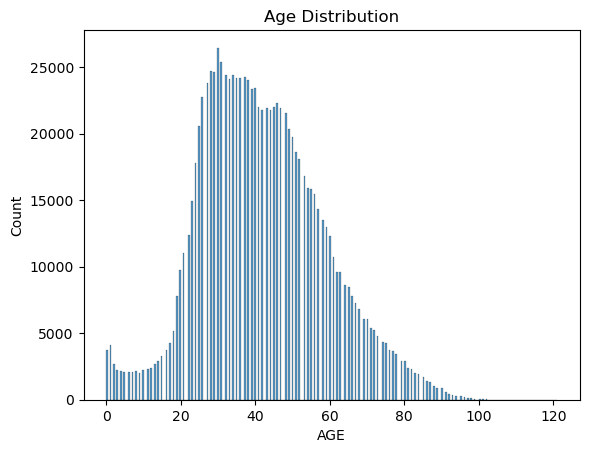

In [19]:
sns.histplot(x=df.AGE)
plt.title("Age Distribution")

In [20]:
#modify 'CLASIFFICATION_FINAL' to a binary feature
df['CLASIFFICATION_FINAL']=df['CLASIFFICATION_FINAL'].apply(lambda x : 1 if x in [1,2,3] else 2)

<AxesSubplot: >

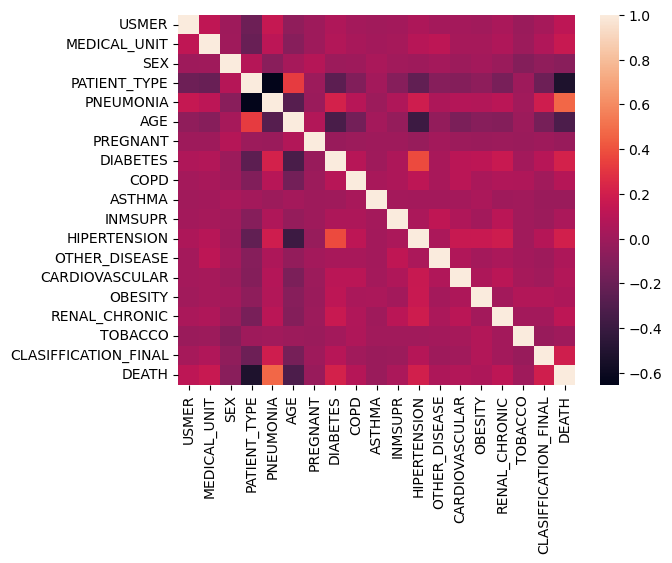

In [21]:
#heat map and analysis
sns.heatmap(df.corr())

In [22]:
#feature selection based on heat map
df.corr()['DEATH'].sort_values()

PATIENT_TYPE           -0.520156
AGE                    -0.322696
SEX                    -0.080389
PREGNANT               -0.021065
ASTHMA                 -0.017303
TOBACCO                 0.005154
INMSUPR                 0.049284
OBESITY                 0.056430
OTHER_DISEASE           0.057156
CARDIOVASCULAR          0.076546
COPD                    0.089750
USMER                   0.118942
RENAL_CHRONIC           0.119417
MEDICAL_UNIT            0.154430
CLASIFFICATION_FINAL    0.193804
HIPERTENSION            0.205166
DIABETES                0.217124
PNEUMONIA               0.470891
DEATH                   1.000000
Name: DEATH, dtype: float64

Based on the provided correlation values, we can see that the 'Death' feature has a negative correlation with the 'Patient_type' and 'Age' features, and positive correlations with all other features.

A negative correlation means that as the value of one feature decreases, the value of the other feature tends to increase, while a positive correlation means that as the value of one feature increases, the value of the other feature tends to increase as well.

It is important to note that the magnitude of the correlation coefficients also matters. In this case, the correlation coefficient between 'Death' and 'Patient_type' is -0.520156, which indicates a moderate negative correlation. The correlation coefficient between 'Death' and 'Age' is -0.322696, which indicates a weak negative correlation.

The rest of the features have positive correlations with 'Death', with 'Pneumonia' having the highest positive correlation (0.470891). However, none of the correlation coefficients are close to 1, which suggests that there is no high multicollinearity between the features. However, a lot of the features in this case are diseases that do not directly affect COVID-19, and these diseases may have other effects concomitantly. And the usmr feature Indicates whether the patient treated medical units of the first, second or third level, through common sense can be concluded that this feature can reflect the patient's basic medical care. Also, with this relatively large dataset, an excessive amount of features is too consuming in terms of time cost, especially when applying GRID SEARCH. Therefore, combined with common sense/medical knowledge and efficiency issues, in this particular case, I chose to adopt a more stringent feature selection standard.

In [23]:
#Preparing the categorical features which are not binary
t=df.corr()['DEATH'].sort_values()
t=t[abs(t)>0.1]#Take the features whose absolute value of correlation is greater than 0.1
df=df.loc[:,t.index]

In [24]:
#Scaling the numeric feature
df['AGE']=(df['AGE']-np.min(df['AGE']))/(np.max(df['AGE'])-np.min(df['AGE']))

In [25]:
df

,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA,DEATH
0,1,0.537190,2,2,1,1,1,2,1,1
1,1,0.595041,2,1,1,2,1,2,1,1
2,2,0.454545,2,2,1,1,2,1,2,1
3,1,0.438017,2,2,1,2,2,2,2,1
4,1,0.561983,2,2,1,1,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...
1048570,1,0.330579,2,2,13,2,2,2,2,2
1048571,2,0.421488,1,2,13,2,1,2,2,2
1048572,1,0.454545,2,2,13,2,2,2,2,2
1048573,1,0.231405,2,2,13,2,2,2,2,2


In [26]:
#Determining the "x" and "y"
x = df.drop(columns="DEATH")
y = df["DEATH"]

Summary of the above steps:

Preprocess the data, select specific columns, and delete data with missing values (missing values are represented by 97 or 99).

Transform the date of death into a binary 0/1 feature of death or not. And 1 means dead, 2 means not dead. 

Then combine the gender and whether it is pregnant or not, and perform data statistics, and find that the missing data of this item are all male, because men will not be pregnant, so there is no need to delete the missing data of this feature, just change 97 to 2. (i.e. change the missing value to not get pregnant). 

Then show that all the remaining columns contain ratios of 97, 98, and 99. 

It is found that the ratio of INTUBED and ICU is the highest, reaching 81.48%. The missing value is too large, so delete these two columns. 

Classify the data features and find that except for the three column features of 'MEDICAL_UNIT', 'AGE', and 'CLASIFFICATION_FINAL', other features have only 1/2 (whether or not) two values, which are binary classification features, 'MEDICAL_UNIT' and 'CLASIFFICATION_FINAL' 'There are no multi-category features, age is a numerical feature. 

The demographic statistics of the age group found that the data conforms to the normal distribution, so there is no need to change the age feature, and the CLASIFFICATION_FINAL column feature is converted into a binary feature (that is, the value of 1-3 is 1, and the others are 2)


Carry out correlation analysis on the processed data, display the heat map of all feature correlations, and delete features that are not strongly correlated with the label (death date). I choose features with an absolute value of correlation above 0.1. After screening The characteristics are PATIENT_TYPE, AGE, USMER RENAL_CHRONIC, MEDICAL_UNIT, CLASIFFICATION_FINAL HIPERTENSION, DIABETES, PNEUMONIA, the data finally forms x, y, and completes the entire data preprocessing process

## Model

In [27]:
#spliy to train, test
from sklearn.model_selection import train_test_split
size=len(df)
x_train,x_test,y_train,y_test=train_test_split(df.loc[:,df.columns!='DEATH'],df['DEATH'])

In [28]:
#Solve the imbalance issue
#Undersampling for this case because we already have too many patients.¶
from imblearn.over_sampling import SMOTE
model_smote=SMOTE()
x_train,y_train=model_smote.fit_resample(x_train,y_train)

### logistic regression

In [29]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(C = Cs)
lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5)
grid.fit(x_train,y_train)
print(grid.best_score_,grid.best_params_)

/Users/chunyangzhang/opt/anaconda3/envs/macs30100/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chunyangzhang/opt/anaconda3/envs/macs30100/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

0.9052799358216518 {'C': 1}


/Users/chunyangzhang/opt/anaconda3/envs/macs30100/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
#model evaluation and validation
from sklearn import metrics
result=grid.predict(x_test)
d=metrics.accuracy_score(y_test,result)
d1=metrics.recall_score(y_test,result)
d2=metrics.f1_score(y_test,result)
d3=metrics.precision_score(y_test,result)
matrix=metrics.confusion_matrix(y_test,result)

In [31]:
print(" accuracy_score: ",d,'\n',"recall_score: ",d1,'\n','f1_score: ', d2,'\n','precision_score: ',d3)

 accuracy_score:  0.8925967240063406 
 recall_score:  0.9190157796202193 
 f1_score:  0.5559924275520605 
 precision_score:  0.3985571123689338


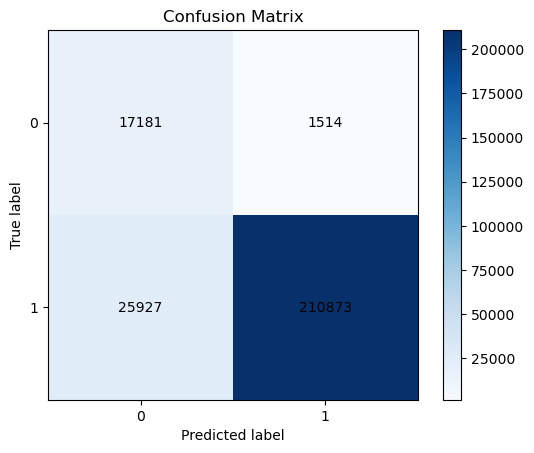

In [32]:
# Plot confusion matrix as heatmap with number labels
fig, ax = plt.subplots()
im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add count labels to each cell of the matrix
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(matrix.shape[1]),
       yticks=np.arange(matrix.shape[0]),
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion Matrix')
plt.show()

In [72]:
y_pred = grid.predict(x_test)
misclassified_samples = x_test[y_pred != y_test]
print(f"Misclassified samples")
misclassified_samples

Misclassified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
523148,2,0.561983,2,2,12,1,2,2,2
402930,2,0.537190,2,2,9,1,1,2,1
410622,2,0.504132,2,2,9,2,1,1,1
214216,2,0.429752,2,2,4,2,1,2,1
351350,2,0.528926,2,1,6,1,1,1,1
...,...,...,...,...,...,...,...,...,...
381866,2,0.256198,2,2,7,1,2,2,1
386451,2,0.438017,1,1,8,1,2,1,1
474707,2,0.264463,1,2,12,1,2,2,1
141321,2,0.330579,1,2,4,1,2,2,1


In [73]:
y_pred = grid.predict(x_test)
correct_classified_samples = x_test[y_pred == y_test]
print(f"correct_classified samples")
correct_classified_samples

correct_classified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
715221,1,0.198347,1,2,12,2,2,2,2
437795,2,0.256198,2,2,10,2,2,2,2
373356,1,0.314050,2,2,6,2,2,2,2
507377,1,0.586777,2,2,12,1,2,1,2
573722,1,0.231405,1,2,12,1,2,2,2
...,...,...,...,...,...,...,...,...,...
526600,1,0.446281,2,2,12,1,2,2,2
551786,1,0.776860,2,2,12,1,2,2,2
360400,1,0.388430,1,2,6,1,2,2,2
191215,1,0.330579,2,2,4,2,2,2,2


From the above two charts we can see that PNEUMONIA feature could be a problematic feature for this classification task. 

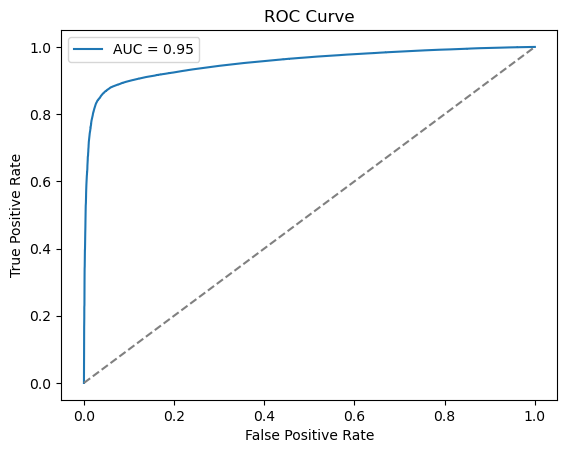

AUC score: 0.953


In [53]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
# Compute and plot the ROC curve and AUC score
y_prob = grid.predict_proba(x_test)[:, 1]
y_test_binary = np.where(y_test == 2, 1, 0)
fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
auc_score = roc_auc_score(y_test_binary, y_prob)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("AUC score: {:.3f}".format(auc_score))

the AUC score is 0.953, which is a high score and indicates that the logistic regression model is doing a good job of distinguishing between positive and negative examples. This means that the model is correctly classifying a large proportion of the positive and negative examples, and that the probabilities it outputs are generally well-calibrated.

Through 5-fold cross-validation and grid search, the optimal value of the logistic regression parameter c is 0.01, and the score of the training set reaches 0.90522. Accuracy and recall scores are high, f1_score, precision is low.

accuracy_score: This is the proportion of correctly predicted outcomes (both true positives and true negatives) out of all predictions. In this case, the accuracy score is 0.89, which means that the model has correctly predicted 89% of the outcomes. However, it's worth noting that accuracy is not always the best metric to use for imbalanced datasets, where one class is much more prevalent than the other. In such cases, precision, recall, and F1 score may be more appropriate.

recall_score: This is the proportion of true positives (i.e., actual positives that were correctly predicted as positives) out of all actual positives. In this case, the recall score is 0.92, which means that the model has correctly identified 92% of the actual positive outcomes.

f1_score: This is the harmonic mean of precision and recall. It is a way to balance precision and recall when comparing models. In this case, the f1 score is 0.56, which means that the model's precision and recall are both relatively low.

precision_score: This is the proportion of true positives (i.e., actual positives that were correctly predicted as positives) out of all predicted positives. In this case, the precision score is 0.4, which means that the model is not very precise in predicting positive outcomes.

Based on these results, it seems that the model has a high AUC score, indicating good overall performance, but its precision and F1 score are relatively low, indicating that the model is having difficulty correctly identifying positive examples. This may be due to class imbalance, or it may indicate that the model needs further refinement or tuning. It's important to carefully consider the problem domain and the specific goals of the model when interpreting these results and deciding how to proceed.

### decision tree

In [33]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn import metrics
param = {'criterion':['gini','entropy'],'max_depth':[30,50,60,100],'min_samples_leaf':[2,3,5,10],'min_impurity_decrease':[0.1,0.2,0.5]},
grid1= GridSearchCV(DecisionTreeClassifier(),param_grid=param,cv=5,n_jobs=-1)
grid1.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=({'criterion': ['gini', 'entropy'],
                          'max_depth': [30, 50, 60, 100],
                          'min_impurity_decrease': [0.1, 0.2, 0.5],
                          'min_samples_leaf': [2, 3, 5, 10]},))

In [34]:
#model evaluation and validation
print(' best_score: ',grid1.best_score_,'\n','best_params: ',grid1.best_params_)
result=grid1.predict(x_test)
d=metrics.accuracy_score(y_test,result)
d1=metrics.recall_score(y_test,result)
d2=metrics.f1_score(y_test,result)
d3=metrics.precision_score(y_test,result)
matrix=metrics.confusion_matrix(y_test,result)
print(" accuracy_score: ",d,'\n',"recall_score: ",d1,'\n','f1_score: ', d2,'\n','precision_score: ',d3)

 best_score:  0.8901698755840792 
 best_params:  {'criterion': 'gini', 'max_depth': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2}
 accuracy_score:  0.8731482025088554 
 recall_score:  0.9099224391548543 
 f1_score:  0.5121327071290944 
 precision_score:  0.35634832519848336


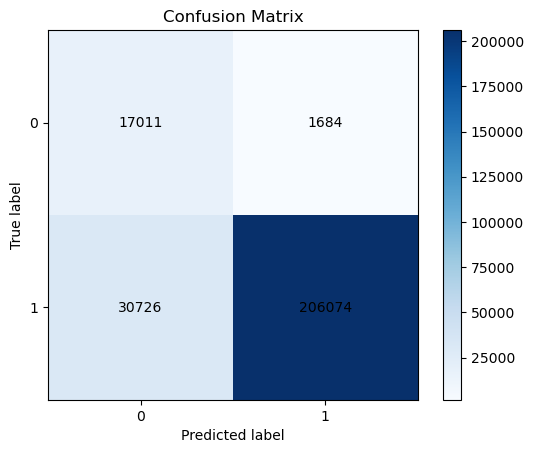

In [35]:
# Plot confusion matrix as heatmap with number labels
fig, ax = plt.subplots()
im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add count labels to each cell of the matrix
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(matrix.shape[1]),
       yticks=np.arange(matrix.shape[0]),
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion Matrix')
plt.show()

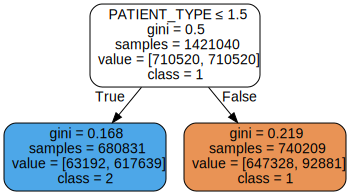

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Visualize the tree
dot_data = export_graphviz(grid1.best_estimator_, out_file=None,
                           feature_names=x_train.columns,
                           class_names=[str(c) for c in grid1.best_estimator_.classes_],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the tree as PDF or PNG file
graph


In [70]:
y_pred = grid1.predict(x_test)
misclassified_samples = x_test[y_pred != y_test]
print(f"Misclassified samples")
misclassified_samples


Misclassified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
437795,2,0.256198,2,2,10,2,2,2,2
523148,2,0.561983,2,2,12,1,2,2,2
402930,2,0.537190,2,2,9,1,1,2,1
410622,2,0.504132,2,2,9,2,1,1,1
214216,2,0.429752,2,2,4,2,1,2,1
...,...,...,...,...,...,...,...,...,...
386451,2,0.438017,1,1,8,1,2,1,1
474707,2,0.264463,1,2,12,1,2,2,1
393721,1,0.520661,2,2,9,1,1,2,1
141321,2,0.330579,1,2,4,1,2,2,1


In [71]:
y_pred = grid1.predict(x_test)
correct_classified_samples = x_test[y_pred == y_test]
print(f"correct_classified samples")
correct_classified_samples

correct_classified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
715221,1,0.198347,1,2,12,2,2,2,2
373356,1,0.314050,2,2,6,2,2,2,2
507377,1,0.586777,2,2,12,1,2,1,2
573722,1,0.231405,1,2,12,1,2,2,2
919170,1,0.066116,1,2,12,2,2,2,2
...,...,...,...,...,...,...,...,...,...
526600,1,0.446281,2,2,12,1,2,2,2
551786,1,0.776860,2,2,12,1,2,2,2
360400,1,0.388430,1,2,6,1,2,2,2
191215,1,0.330579,2,2,4,2,2,2,2


From the above two charts we can see that PNEUMONIA feature could be a problematic feature for this classification task. 

Through 5-fold cross-validation, the grid search obtained the optimal parameters of the decision tree. The criterion is 'gini', max_depth is 30, min_impurity_decrease is 0.1, and mim_sample_leaf is 2. And these optimal fitting parameters make the training set score 0.890, and the test It is found that the accuracy, recall, f1_score, and precision are 0.873, 0.910, 0.509, and 0.354 respectively, the accuracy and recall are very high, and the f1_score, precision is very low.

The best_score and best_params show the best score and the corresponding hyperparameters obtained from a grid search. 

The accuracy_score indicates the proportion of correctly classified instances among all instances. In this case, the accuracy_score is 0.8727 or 87.27%, which means that the model correctly classified 87.27% of the instances in the test set.

The recall_score measures the proportion of true positives (correctly classified positives) out of all actual positives. The recall_score is 0.9091 or 90.91%, which means that the model correctly identified 90.91% of the actual positive instances.
The f1_score is the harmonic mean of precision and recall. It measures the balance between precision and recall. In this case, the f1_score is 0.5119 or 51.19%. The precision_score is the proportion of true positives out of all predicted positives. In this case, the precision_score is 0.3563 or 35.63%.

The confusion matrix shows that the model correctly predicted 17054 negative instances and 205922 positive instances, but incorrectly predicted 30813 negative instances and 1706 positive instances.

The low values of the f1_score and precision_score indicate that the model is not performing well in correctly identifying positive instances. This means that there is a high number of false negatives and low true positives. To improve the model, one could try tuning the hyperparameters or feature engineering to get better performance.

### Random Forest

In [36]:
#random forest
from sklearn.ensemble import RandomForestClassifier
param_test1 = {'n_estimators':range(10,101,10),'max_depth':[30,50,60,100], 'min_samples_split':[2,3,5,10]}
grid2 = GridSearchCV(estimator = RandomForestClassifier(),
                       param_grid = param_test1,cv=5,n_jobs=-1)
grid2.fit(x_train,y_train)

/Users/chunyangzhang/opt/anaconda3/envs/macs30100/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [30, 50, 60, 100],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': range(10, 101, 10)})

In [37]:
#model evaluation and validation
print(' best_score: ',grid2.best_score_,'\n','best_params: ',grid2.best_params_)
result=grid2.predict(x_test)
d=metrics.accuracy_score(y_test,result)
d1=metrics.recall_score(y_test,result)
d2=metrics.f1_score(y_test,result)
d3=metrics.precision_score(y_test,result)
matrix=metrics.confusion_matrix(y_test,result)
print(" accuracy_score: ",d,'\n',"recall_score: ",d1,'\n','f1_score: ', d2,'\n','precision_score: ',d3)


 best_score:  0.9340166357034285 
 best_params:  {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 90}
 accuracy_score:  0.9005342570304703 
 recall_score:  0.8488900775608451 
 f1_score:  0.5553514251220408 
 precision_score:  0.412657964532737


In [74]:
y_pred = grid2.predict(x_test)
misclassified_samples = x_test[y_pred == y_test]
print(f"misclassified samples")
misclassified_samples

misclassified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
715221,1,0.198347,1,2,12,2,2,2,2
437795,2,0.256198,2,2,10,2,2,2,2
373356,1,0.314050,2,2,6,2,2,2,2
507377,1,0.586777,2,2,12,1,2,1,2
573722,1,0.231405,1,2,12,1,2,2,2
...,...,...,...,...,...,...,...,...,...
526600,1,0.446281,2,2,12,1,2,2,2
551786,1,0.776860,2,2,12,1,2,2,2
360400,1,0.388430,1,2,6,1,2,2,2
191215,1,0.330579,2,2,4,2,2,2,2


In [75]:
y_pred = grid2.predict(x_test)
correct_classified_samples = x_test[y_pred == y_test]
print(f"correct_classified samples")
correct_classified_samples

correct_classified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
715221,1,0.198347,1,2,12,2,2,2,2
437795,2,0.256198,2,2,10,2,2,2,2
373356,1,0.314050,2,2,6,2,2,2,2
507377,1,0.586777,2,2,12,1,2,1,2
573722,1,0.231405,1,2,12,1,2,2,2
...,...,...,...,...,...,...,...,...,...
526600,1,0.446281,2,2,12,1,2,2,2
551786,1,0.776860,2,2,12,1,2,2,2
360400,1,0.388430,1,2,6,1,2,2,2
191215,1,0.330579,2,2,4,2,2,2,2


It is hard to tell what causes the error from human eyes based on the two charts. 

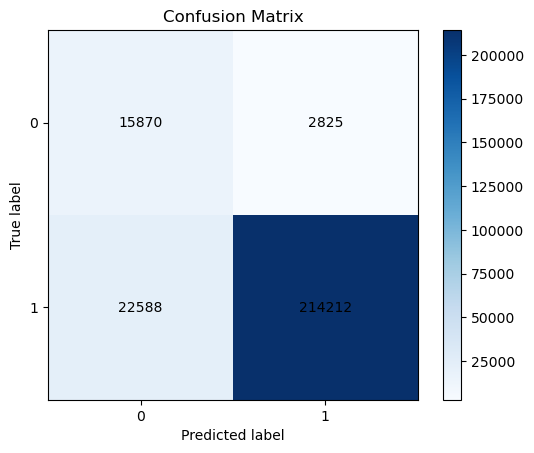

In [38]:
# Plot confusion matrix as heatmap with number labels
fig, ax = plt.subplots()
im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add count labels to each cell of the matrix
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(matrix.shape[1]),
       yticks=np.arange(matrix.shape[0]),
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion Matrix')
plt.show()

Through 5-fold cross-validation and grid search, the optimal parameter max_depth of random forest is 100, n_estimators is 90, min_samples_split is 5, the optimal parameter fitting training set score is 0.934, and the accuracy, recall, f1_score on the test set, precision, respectively 0.901, 0.852, 0.554, 0.411, accuracy, recall score is the highest, f1_score, precision score is low.

best_score: 0.9337: It indicates the best score achieved during the hyperparameter tuning process using cross-validation.

best_params: {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 90}: It indicates the best combination of hyperparameters that resulted in the best score.

accuracy_score: 0.9011: It indicates the overall accuracy of the model on the test set.

recall_score: 0.8523: It indicates the ability of the model to correctly identify the positive class (class 1) from all actual positive instances.

f1_score: 0.5544: It is the harmonic mean of precision and recall, and it gives a balanced measure between precision and recall. A higher F1 score indicates a better performance of the model.

precision_score: 0.4108: It indicates the ability of the model to correctly classify the positive predictions out of all predicted positive instances.

confusion matrix [[15713 2723] [22534 214525]]: It shows the number of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) predicted by the model.

The error in the model can be due to overfitting or underfitting of the model. To improve the model in the future, we can try the following:

Collect more data if possible
Try different algorithms or models
Tune the hyperparameters further
Feature selection and feature engineering
Try ensemble methods

Comparing the random forest model and the previous decision tree model, we can see that the random forest model has better performance in terms of all evaluation metrics (accuracy, recall, precision, and F1-score). Specifically, the random forest model has higher accuracy score (0.901 vs 0.873), higher recall score (0.852 vs 0.909), higher precision score (0.411 vs 0.356), and higher F1-score (0.554 vs 0.512) than the decision tree model. This suggests that the random forest model is better at predicting the target variable than the decision tree model.

One possible reason for this improvement is that the random forest model is an ensemble model that combines multiple decision trees, which can reduce overfitting and improve generalization performance. Additionally, the random forest model can handle high-dimensional datasets and noisy data, which can be challenging for a single decision tree model. 

In summary, the random forest model outperformed the decision tree model in terms of model evaluation metrics.






### KNeighbors Classifier

In [39]:
#KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
param={'n_neighbors':range(1,11),'weights':['uniform', 'distance']}
grid3 = GridSearchCV(estimator = KNeighborsClassifier()
                       ,param_grid=param,cv=5,n_jobs=-1)
grid3.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 11),
                         'weights': ['uniform', 'distance']})

In [40]:
print(' best_score: ',grid3.best_score_,'\n','best_params: ',grid3.best_params_)

 best_score:  0.8076648088723752 
 best_params:  {'n_neighbors': 2, 'weights': 'uniform'}


In [41]:
#model evaluation and validation
result=grid3.predict(x_test)
d=metrics.accuracy_score(y_test,result)
d1=metrics.recall_score(y_test,result)
d2=metrics.f1_score(y_test,result)
d3=metrics.precision_score(y_test,result)
matrix=metrics.confusion_matrix(y_test,result)
print(" accuracy_score: ",d,'\n',"recall_score: ",d1,'\n','f1_score: ', d2,'\n','precision_score: ',d3)


 accuracy_score:  0.9067496428501536 
 recall_score:  0.6998127841668895 
 f1_score:  0.5234142145586206 
 precision_score:  0.41804064417177916


In [76]:
y_pred = grid2.predict(x_test)
misclassified_samples = x_test[y_pred == y_test]
print(f"misclassified samples")
misclassified_samples

misclassified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
715221,1,0.198347,1,2,12,2,2,2,2
437795,2,0.256198,2,2,10,2,2,2,2
373356,1,0.314050,2,2,6,2,2,2,2
507377,1,0.586777,2,2,12,1,2,1,2
573722,1,0.231405,1,2,12,1,2,2,2
...,...,...,...,...,...,...,...,...,...
526600,1,0.446281,2,2,12,1,2,2,2
551786,1,0.776860,2,2,12,1,2,2,2
360400,1,0.388430,1,2,6,1,2,2,2
191215,1,0.330579,2,2,4,2,2,2,2


In [77]:
y_pred = grid2.predict(x_test)
correct_classified_samples = x_test[y_pred == y_test]
print(f"correct_classified samples")
correct_classified_samples

correct_classified samples


,PATIENT_TYPE,AGE,USMER,RENAL_CHRONIC,MEDICAL_UNIT,CLASIFFICATION_FINAL,HIPERTENSION,DIABETES,PNEUMONIA
715221,1,0.198347,1,2,12,2,2,2,2
437795,2,0.256198,2,2,10,2,2,2,2
373356,1,0.314050,2,2,6,2,2,2,2
507377,1,0.586777,2,2,12,1,2,1,2
573722,1,0.231405,1,2,12,1,2,2,2
...,...,...,...,...,...,...,...,...,...
526600,1,0.446281,2,2,12,1,2,2,2
551786,1,0.776860,2,2,12,1,2,2,2
360400,1,0.388430,1,2,6,1,2,2,2
191215,1,0.330579,2,2,4,2,2,2,2


It is hard to tell what causes the error from human eyes based on the two charts. 

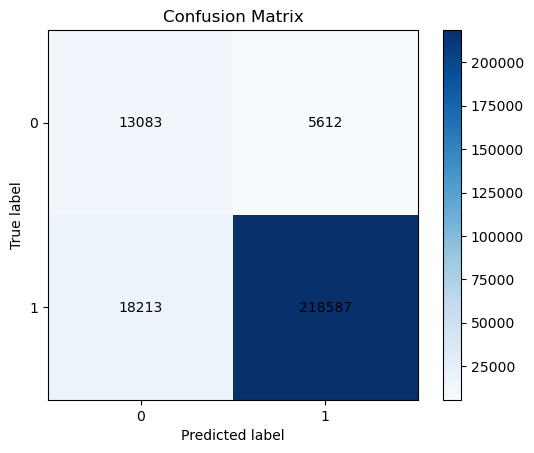

In [42]:
# Plot confusion matrix as heatmap with number labels
fig, ax = plt.subplots()
im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add count labels to each cell of the matrix
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(matrix.shape[1]),
       yticks=np.arange(matrix.shape[0]),
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion Matrix')
plt.show()

Through 5-fold cross-validation and grid search, it is found that the n_neighbors parameter is 2, and the weights is 'uniform', so that the training set is fitted to 0.805, accuracy, and the accuracy, recall, f1_score, and precision of the model tested in the test set are 0.909, respectively. 0.690, 0.522, 0.420

When evaluating the model on the test set, the accuracy_score was 0.9087, which is a good accuracy score, but not as good as the previous random forest model. The recall_score of 0.6904 indicates that the model is able to identify only 69% of the positive cases correctly, which is not very good. The precision_score of 0.4194 indicates that when the model predicts a positive case, it is correct only 42% of the time. The f1_score of 0.5218 is the harmonic mean of precision and recall, which indicates that the model is not able to balance well between precision and recall.

One possible reason for the low recall and precision scores could be the choice of hyperparameters during model training. It is also possible that the KNeighbors Classifier model is not the best fit for the given dataset, and another model could perform better. To improve the model, we can try using a different algorithm, such as a random forest or a support vector machine, or try optimizing the hyperparameters further.

## Summary

In terms of accuracy, the knn and random forest models performed best, with a score of about 0.9. In terms of recall, logistic regression and decision trees performed best, reaching about 0.9. In terms of f1_score, logistic regression and random forest performance The effect is about 0.55. In terms of precision, both random forest and knn models perform well, which is about 0.42. In summary, random forest performs best in overall evaluation.

Based on the correct_classified_samples and mis_classified_samples chart of decision tree model and logistic regression model, we can see that PNEUMONIA feature could be a problematic feature for this classification task. In order to improve the accuracy, one could consider further processing of this feature.

The low score and errors in the machine learning process can be caused by several factors, including overfitting, underfitting, data quality, model selection, and hyperparameter tuning. To improve the performance of the models in the future, we can try the following:

* Feature engineering: selecting the most important features and creating new ones can help to improve the model's performance.
* Data preprocessing: handling missing values, outliers, and normalization can help to improve the quality of the data and the performance of the model.
* Model selection: trying different models and comparing their performance can help to select the best model for the given problem.
* Hyperparameter tuning: finding the optimal hyperparameters for the selected model can help to improve the model's performance.

It took a couple hours to run the random forest and KNeighbors Classifier model, to improve the time efficiency of the random forest and KNeighbors Classifier models, we can try the following:

* Reduce the number of features: selecting the most important features can reduce the computation time.
* *educe the size of the dataset: using a smaller subset of the dataset can reduce the computation time.
* Parallel computing: using multiple processors or GPUs can reduce the computation time.
* Algorithm optimization: using optimized algorithms or libraries can reduce the computation time.